# Imports

In [1]:
import sys
import os
import numpy as np
import numpy.lib.recfunctions as nprf
from sklearn import linear_model
import matplotlib as mpl
import time
import scipy
import pickle

from collections import OrderedDict

from scipy.stats import gaussian_kde
from importlib import reload
import pandas as pd


from mpl_toolkits.mplot3d import Axes3D

mpl.use('Agg')

mpl.rcParams['figure.figsize'] = (7,7)
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams.update({'font.size':22})

% matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams["text.usetex"] =True

In [2]:
import tools.matt_tools as matt

reload(matt)

from tools.catalog import Catalog

In [3]:
wdir = '/home/mho1/scratch/halo_cnn'
imdir = '/home/mho1/halo_cnn/paper_images'

# Flat Test number density

In [20]:
hmf_M200c = np.loadtxt(os.path.join(wdir, 'data_raw/dn_dm_MDPL2_z=0.117_M200c.txt'))

x_hmf_M200c, y_hmf_M200c = hmf_M200c

y_hmf_M200c = x_hmf_M200c*y_hmf_M200c*np.log(10)
x_hmf_M200c = np.log10(x_hmf_M200c)

In [21]:
def flat_test(test,pred, n=40, n_per_bin=100):
    bin_edges = np.linspace(test.min(), test.max(),n)
    
    bins = [np.argwhere( (test >= bin_edges[i])&(test <= bin_edges[i+1]) ).flatten() \
            for i in range(len(bin_edges)-1)]
    
    print(len(bins[0]))
    
#     n_per_bin = len(min(bins, key=lambda x: len(x)))
    print('n_per_bin:', n_per_bin)
    
    bins = [np.random.choice(bins[i], n_per_bin, replace=True) for i in range(len(bins))]
    
    bins = np.array(bins).flatten()
    
    return test[bins], pred[bins]
    
test,pred = flat_test(cnn_dat['logmass_test'],cnn_dat['logmass_pred'])

2755
n_per_bin: 100


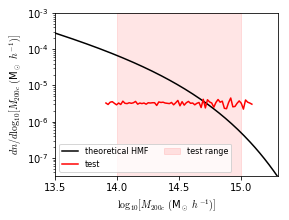

In [28]:
f = plt.figure(figsize=(4,3))
ax3 = f.add_subplot(111)

ax3.plot(x_hmf_M200c,y_hmf_M200c, label='theoretical HMF', c='k')

test_range=(14,15)
ax3.axvspan(*test_range,
           alpha=0.1, color='r', label='test range')
# n = matt.histplot(data_proc['logmass'][data_proc['in_train'] & (data_proc['fold']!=0)], 
#                   n=100, log=1, box=True, label='train', c='g', ax=ax3)
_ = matt.histplot(test, 
                  n=70, log=1, box=True, label='test', c='r', ax=ax3, func=lambda x: x)

ax3.set_xlabel(r'$\log_{10}[M_{200c}\ ($M$_\odot\ h^{-1})]$', fontsize=10)
ax3.set_ylabel('$dn/d\log_{10}[M_{200c}\ ($M$_\odot\ h^{-1})]$',fontsize=10)
ax3.set_ylim(10**-7.5, 10**-3)
ax3.set_xlim(13.5,
             15.3)

# handles, labels = plt.gca().get_legend_handles_labels()
# order = [0,3,1,2]
# ax3.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#           ncol=2, loc=3, fontsize=8)
ax3.legend(ncol=2, loc=3, fontsize=8)

# ax3.set_xlim(xmin=data_proc['logmass'].min(), xmax=data_proc['logmass'].max())
f.savefig(os.path.join(imdir, 'hmf.png'),bbox_inches='tight')

# Results

## 1D

In [31]:
model_name = 'halo_cnn1d_r'
model_num = 152

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

cnn_dat = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
cnn_par = cnn_dat['params']

one_to_one = np.arange(11)*(cnn_par['logmass_max'] - cnn_par['logmass_min'])/10. + cnn_par['logmass_min']


In [32]:
# Cut on Mpred
# cnn_dat['logmass_test'] = cnn_dat['logmass_test'][cnn_dat['logmass_pred'] > 14]
# cnn_dat['logmass_pred'] = cnn_dat['logmass_pred'][cnn_dat['logmass_pred'] > 14]

cnn_dat['logmass_test'],cnn_dat['logmass_pred'] = flat_test(cnn_dat['logmass_test'],cnn_dat['logmass_pred'])

7646
n_per_bin: 100


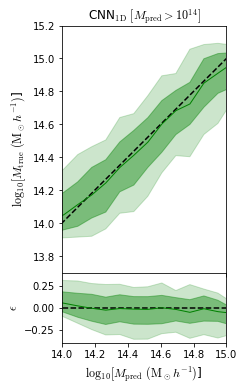

In [36]:
f = plt.figure(figsize=[3.5,6])
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[4,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(one_to_one,one_to_one, color='k', linestyle='dashed')

matt.binnedplot( cnn_dat['logmass_pred'],cnn_dat['logmass_test'], n=20, 
            percentiles=[34,47], median=True, ax=ax1, log=0, c='g'
            )
ax1.set_ylabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

ax1.set_xticklabels([])
ax1.set_xlim(xmin=14, xmax=15)
ax1.set_ylim(ymin=13.7, ymax=15.2)
ax1.set_aspect(aspect='equal',adjustable='box', anchor='S')


# pred_err = (10.**cnn_dat['logmass_pred'])/(10.**cnn_dat['logmass_test']) - 1.
pred_err = cnn_dat['logmass_test'] - cnn_dat['logmass_pred']

ax2 = f.add_subplot(gs[1,0])# , sharex=ax1)
ax2.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(cnn_dat['logmass_pred'],pred_err,n=20, percentiles=[34, 47], 
                median=True, ax=ax2, label='cnn',c='g', errorbar=False, names=False, log=0)

ax2.set_xlim(xmin=14, xmax=15)

ax2.set_ylim(ymin=-0.4,ymax=0.4)
ax2.set_ylabel(r'$\epsilon$',fontsize=12)
ax2.set_xlabel(r'$\log_{10}[M_\mathrm{pred}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

# ax2.set_yticklabels([-0.5,0,1])


ax1.set_title('CNN$_\mathrm{1D}\ [M_\mathrm{pred}>10^{14}]$', fontsize=12)

plt.tight_layout()

f.savefig(os.path.join(imdir,'pred_1d.png'),bbox_inches='tight', dpi=300)

## 2D

In [37]:
model_name = 'halo_cnn2d_r'
model_num = 67 # bwidth=0.25
# model_num=57 # bwidth=0.15


data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

cnn_dat = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
cnn_par = cnn_dat['params']

one_to_one = np.arange(11)*(cnn_par['logmass_max'] - cnn_par['logmass_min'])/10. + cnn_par['logmass_min']

print(cnn_par['bandwidth'])

0.25


In [38]:
# Cut on Mpred
# cnn_dat['logmass_test'] = cnn_dat['logmass_test'][cnn_dat['logmass_pred'] > 14]
# cnn_dat['logmass_pred'] = cnn_dat['logmass_pred'][cnn_dat['logmass_pred'] > 14]

cnn_dat['logmass_test'],cnn_dat['logmass_pred'] = flat_test(cnn_dat['logmass_test'],cnn_dat['logmass_pred'])

7646
n_per_bin: 100


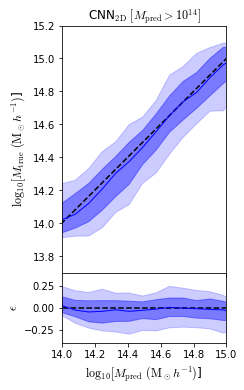

In [40]:
s=1

f = plt.figure(figsize=[3.5,6])
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[4,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(one_to_one,one_to_one, color='k', linestyle='dashed')

# ax1.plot(cnn_dat['logmass_test'][cnn_dat['logmass_test']>15.05],
#          cnn_dat['logmass_pred'][cnn_dat['logmass_test']>15.05],'.', c='r'
#         )
matt.binnedplot(cnn_dat['logmass_pred'], cnn_dat['logmass_test'], n=20, 
            percentiles=[34,47], median=True, ax=ax1, log=0, c='b'
            )


ax1.set_ylabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

ax1.set_xticklabels([])
ax1.set_xlim(xmin=14, xmax=15)
ax1.set_ylim(ymin=13.7, ymax=15.2)
ax1.set_aspect(aspect='equal',adjustable='box', anchor='S')


# pred_err = (10.**cnn_dat['logmass_pred'])/(10.**cnn_dat['logmass_test']) - 1.
pred_err =  cnn_dat['logmass_test'] - cnn_dat['logmass_pred']

ax2 = f.add_subplot(gs[1,0])# , sharex=ax1)
ax2.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(cnn_dat['logmass_pred'],pred_err,n=20, percentiles=[34, 47], 
                median=True, ax=ax2, label='cnn',c='b', errorbar=False, names=False, 
                log=0)#, err_lines=True, linestyle='--')

ax2.set_xlim(xmin=14, xmax=15)

ax2.set_ylim(ymin=-0.4,ymax=0.4)
ax2.set_ylabel(r'$\epsilon$',fontsize=12)
ax2.set_xlabel(r'$\log_{10}[M_\mathrm{pred}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

# ax2.set_yticklabels([-1,0,1])


ax1.set_title('CNN$_\mathrm{2D}\ [M_\mathrm{pred}>10^{14}]$', fontsize=12)

plt.tight_layout()

f.savefig(os.path.join(imdir,'pred_2d.png'),bbox_inches='tight', dpi=300)

## All

In [66]:
print('\n~~~~~ LOADING SDM DATA ~~~~~~')

model_name = 'halo_sdm1d'
model_num = 20

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

sdm_dat_1d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()

# Cut on Mpred
sdm_dat_1d['logmass_test'] = sdm_dat_1d['logmass_test'][sdm_dat_1d['logmass_pred'] > 14]
sdm_dat_1d['logmass_pred'] = sdm_dat_1d['logmass_pred'][sdm_dat_1d['logmass_pred'] > 14]

sdm_err_1d = sdm_dat_1d['logmass_pred'] - sdm_dat_1d['logmass_test']


model_name = 'halo_sdm2d'
model_num = 10

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

sdm_dat_2d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
sdm_dat_2d['fold'] = np.array([[i]*int(len(sdm_dat_2d['logmass_pred'])/10) for i in range(10)]).flatten()
sdm_dat_2d['fold'] = np.array(list(sdm_dat_2d['fold']) + [9]*(len(sdm_dat_2d['logmass_pred']) - len(sdm_dat_2d['fold'])))

sdm_dat_2d['logmass_pred'] = sdm_dat_2d['logmass_pred'][sdm_dat_2d['fold']!=7]
sdm_dat_2d['logmass_test'] = sdm_dat_2d['logmass_test'][sdm_dat_2d['fold']!=7]
sdm_dat_2d['fold'] = sdm_dat_2d['fold'][sdm_dat_2d['fold']!=7]

# Cut on Mpred
sdm_dat_2d['logmass_test'] = sdm_dat_2d['logmass_test'][sdm_dat_2d['logmass_pred'] > 14]
sdm_dat_2d['logmass_pred'] = sdm_dat_2d['logmass_pred'][sdm_dat_2d['logmass_pred'] > 14]

sdm_err_2d = sdm_dat_2d['logmass_pred'] - sdm_dat_2d['logmass_test']



~~~~~ LOADING SDM DATA ~~~~~~


In [67]:
print('\n~~~~~ LOADING CNN DATA ~~~~~~')

model_name = 'halo_cnn1d_r'
model_num = 152

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

cnn_dat_1d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
cnn_par = cnn_dat_1d['params']

# Cut on Mpred
cnn_dat_1d['logmass_test'] = cnn_dat_1d['logmass_test'][cnn_dat_1d['logmass_pred'] > 14]
cnn_dat_1d['logmass_pred'] = cnn_dat_1d['logmass_pred'][cnn_dat_1d['logmass_pred'] > 14]
pred_err_1d = cnn_dat_1d['logmass_pred'] - cnn_dat_1d['logmass_test']

model_name = 'halo_cnn2d_r'
# model_num = 67 # bwidth=0.25
model_num=57 # bwidth=0.15

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

cnn_dat_2d = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
cnn_par = cnn_dat_2d['params']

# Cut on Mpred
cnn_dat_2d['logmass_test'] = cnn_dat_2d['logmass_test'][cnn_dat_2d['logmass_pred'] > 14]
cnn_dat_2d['logmass_pred'] = cnn_dat_2d['logmass_pred'][cnn_dat_2d['logmass_pred'] > 14]

pred_err_2d = cnn_dat_2d['logmass_pred'] - cnn_dat_2d['logmass_test']

one_to_one = np.arange(11)*(cnn_par['logmass_max'] - cnn_par['logmass_min'])/10. + cnn_par['logmass_min']



~~~~~ LOADING CNN DATA ~~~~~~


In [68]:
sdm_file = 'data_raw/MDPL2_0.25_MLv_0_preds.npy'

print('\n~~~~~ LOADING REGRESSION DATA ~~~~~~')
with open(os.path.join(data_dir, model_name_save, model_name_save + '_regr.p'),'rb') as f:
    regr_data = pickle.load(f)
pure_regr_pred = regr_data['pure']['pred']
contam_regr_pred = regr_data['contam']['pred']

print('\n~~~~~ CALCULATING MASS ERROR ~~~~~')
# PURE

pure_regr_err = pure_regr_pred['logmass_pred'][pure_regr_pred['in_test'] & (pure_regr_pred['logmass_pred'] > 14)] - \
                pure_regr_pred['logmass'][pure_regr_pred['in_test'] & (pure_regr_pred['logmass_pred'] > 14)]

# CONTAM

contam_regr_err =   contam_regr_pred['logmass_pred'][contam_regr_pred['in_test'] & (contam_regr_pred['logmass_pred'] > 14)] - \
                    contam_regr_pred['logmass'][contam_regr_pred['in_test'] & (contam_regr_pred['logmass_pred'] > 14)]


~~~~~ LOADING REGRESSION DATA ~~~~~~

~~~~~ CALCULATING MASS ERROR ~~~~~


/home/mho1/miniconda2/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/mho1/miniconda2/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [69]:
pure_regr_err

array([ 0.52222633,  0.60774803,  0.50945187, ..., -0.17920494,
       -0.03290272, -0.17156887], dtype=float32)

/home/mho1/miniconda2/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater
/home/mho1/miniconda2/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater


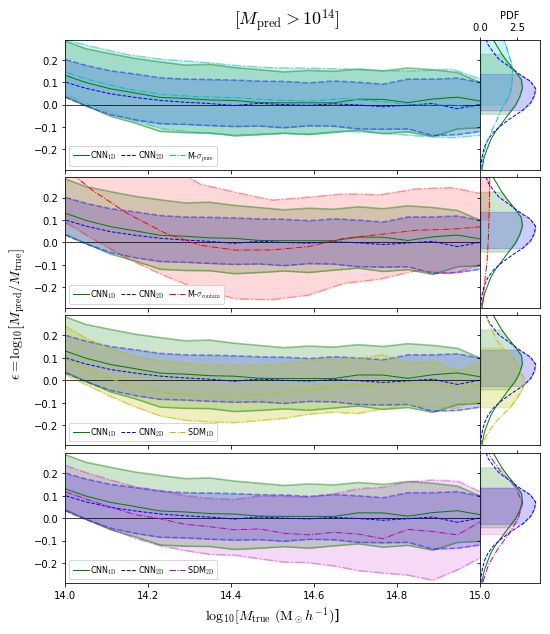

In [70]:
f = plt.figure(figsize=[8.5,10])
gs = mpl.gridspec.GridSpec(4,2,hspace=0.06, wspace=0.0, width_ratios=[7,1])

def compare_pdf(ax, logmass, err, name, c, linestyle='-', alpha=0.2):
    h_val, h_bin = np.histogram(err, bins=50, density=True)
    
    h_bin = np.array([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)])
    ax.plot( h_val, h_bin,
                label=name, c=c, lw=1, linestyle=linestyle)
    
    pc = np.percentile(err, [16,84])
    
    plt.fill_betweenx(h_bin[(h_bin>=pc[0])&(h_bin<=pc[1])],0,h_val[(h_bin>=pc[0])&(h_bin<=pc[1])],
                      color=c, alpha=alpha
                     )

def comparison_plot(y, logmass, err, name, c, linestyle='-.', alpha=0.2, null_x=True):
    ax = f.add_subplot(gs[y,0])
    
    ax.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='-', lw=0.75)

    matt.binnedplot(cnn_dat_1d['logmass_test'],pred_err_1d,n=20, percentiles=[34], 
                    median=True, ax=ax, label=r'CNN$_\mathrm{1D}$',c='g', errorbar=False, 
                    names=False, log=0, linestyle='-', err_lines=True, lw=1., alpha=0.2)
    matt.binnedplot(cnn_dat_2d['logmass_test'],pred_err_2d,n=20, percentiles=[34], 
                    median=True, ax=ax, label=r'CNN$_\mathrm{2D}$',c='b', errorbar=False, 
                    names=False, log=0, linestyle='--', err_lines=True, lw=1., alpha=0.2)
    
    matt.binnedplot(logmass,
                    err,
                    n=20, percentiles=[34], median=True, ax=ax, 
                    label=name,c=c, errorbar=False, names=False, 
                    log=0, linestyle=linestyle, err_lines=True, lw=1., alpha=alpha)
    
    ax.set_xlim(xmin=14,xmax=15)
    
    ax.set_ylim(ymin=-0.29,ymax=0.29)
#     ax1.set_ylabel(r'$\epsilon$',fontsize=14)
    # ax1.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)
    if null_x: ax.xaxis.set_major_formatter(plt.NullFormatter())
    else: ax.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=14)

    plt.legend(ncol=3, loc=3, fontsize=8, 
               handletextpad=0.2, columnspacing=0.5#, handlelength=1.3
              )
    
    ax_1 = f.add_subplot(gs[y,1])
    
    compare_pdf(ax_1,cnn_dat_1d['logmass_test'],pred_err_1d,r'CNN$_\mathrm{1D}$',
                c='g', linestyle='-', alpha=0.2)
    compare_pdf(ax_1,cnn_dat_2d['logmass_test'],pred_err_2d,r'CNN$_\mathrm{1D}$',
                c='b', linestyle='--', alpha=0.2)
    compare_pdf(ax_1, logmass,err,name,c, linestyle='-.', alpha=alpha)
    
    ax_1.set_ylim(-0.29,0.29)
    ax_1.set_xlim(0,4)
    ax_1.xaxis.tick_top()
    
    ax_1.yaxis.set_major_formatter(plt.NullFormatter())
    if y>0: ax_1.xaxis.set_major_formatter(plt.NullFormatter())
    else: 
        ax_1.xaxis.set_label_position('top') 
        ax_1.set_xlabel('PDF')
    return ax

ax1 = comparison_plot(0,pure_regr_pred['logmass'][pure_regr_pred['in_test']& (pure_regr_pred['logmass_pred'] > 14)], 
                      pure_regr_err, 
                      name='M-$\sigma_\mathrm{pure}$', c='c', alpha=0.2, linestyle='-.'
                     )
ax2 = comparison_plot(1,contam_regr_pred['logmass'][contam_regr_pred['in_test']& (contam_regr_pred['logmass_pred'] > 14)],
                      contam_regr_err,
                      name='M-$\sigma_\mathrm{contam}$', c='r', alpha=0.15
                     )
ax3 = comparison_plot(2,sdm_dat_1d['logmass_test'],sdm_err_1d,
                      name=r'SDM$_\mathrm{1D}$', c='y', alpha=0.25
                     )
ax4 = comparison_plot(3,sdm_dat_2d['logmass_test'],sdm_err_2d,
                      name=r'SDM$_\mathrm{2D}$', c='m', alpha=0.15, null_x=False
                     )

f.text(0.03, 0.5, r'$\epsilon = \log_{10}\left[M_\mathrm{pred}/M_\mathrm{true}\right]$', 
       va='center', rotation='vertical',fontsize=14)


f.text(0.40,0.9, s=r'$[M_\mathrm{pred}>10^{14}]$', 
       rotation='horizontal',fontsize=18)

f.savefig(os.path.join(imdir,'err_all.png'),bbox_inches='tight', dpi=500) 

# Log-normality

In [71]:
def plot_pdf(logmass, pred_err,ax,name, norm=True, c='b', linestyle='-', dashes=None):
    err = pred_err[(logmass>14)&(logmass<15)]
    sig = np.std(err)
    err = (err-np.mean(err))/sig
    h_val, h_bin = np.histogram(err, bins=50, density=True)
    
    sig_str = str(round(sig,3))
    name += '; $\sigma_\epsilon=$'+ sig_str+'0'*(5-len(sig_str))
    if dashes is None:
        ax.plot([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)], h_val, 
                label=name, c=c, lw=1.5,linestyle=linestyle)
    else:
        ax.plot([np.mean(h_bin[i:i+2]) for i in range(len(h_bin)-1)], h_val, 
                label=name, c=c, lw=1.5,linestyle=linestyle,dashes=dashes)


/home/mho1/miniconda2/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/mho1/miniconda2/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


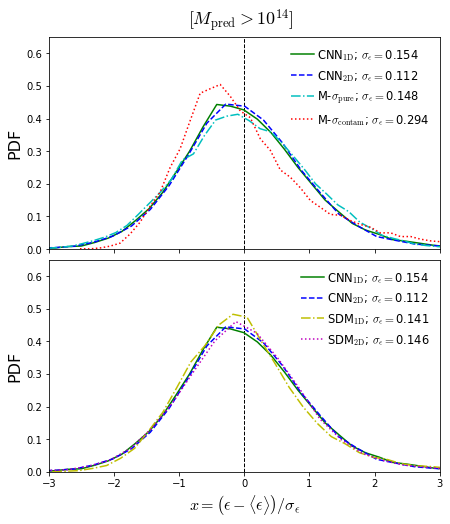

In [73]:
f = plt.figure(figsize=[7,8])
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[1,1], hspace=0.05)

#~~~~ Upper
ax1 = f.add_subplot(gs[0,0])
ax1.axvline(0,c='k',linestyle='--', lw=1)    

plot_pdf(cnn_dat_1d['logmass_test'],pred_err_1d,ax1,'CNN$_\mathrm{1D}$',
         c='g',linestyle='-')
plot_pdf(cnn_dat_2d['logmass_test'], pred_err_2d,ax1,'CNN$_\mathrm{2D}$',
         c='b',linestyle='--')

plot_pdf(pure_regr_pred['logmass'][pure_regr_pred['in_test']& (pure_regr_pred['logmass_pred'] > 14)], 
         pure_regr_err,ax1,'M-$\sigma_\mathrm{pure}$',
         c='c',linestyle='-.')
plot_pdf(contam_regr_pred['logmass'][contam_regr_pred['in_test']& (contam_regr_pred['logmass_pred'] > 14)], 
         contam_regr_err,ax1,'M-$\sigma_\mathrm{contam}$',
         c='r',linestyle=':')


ax1.set_ylabel('PDF', fontsize=16)
# ax1.set_xlabel(r'$x = \left(\epsilon - \langle \epsilon \rangle \right)/\mathrm{Var}[\epsilon]^{1/2}$', fontsize=14)
ax1.set_xlim(-3,3)
ax1.set_ylim(0,0.65)

ax1.xaxis.set_major_formatter(plt.NullFormatter())

plt.legend(loc=0, ncol=1, fontsize=11.5, handletextpad=0.25, columnspacing=1, frameon=False)


#~~~~ Lower
ax2 = f.add_subplot(gs[1,0])
ax2.axvline(0,c='k',linestyle='--', lw=1)    

plot_pdf(cnn_dat_1d['logmass_test'],pred_err_1d,ax2,'CNN$_\mathrm{1D}$',
         c='g',linestyle='-')
plot_pdf(cnn_dat_2d['logmass_test'], pred_err_2d,ax2,'CNN$_\mathrm{2D}$',
         c='b',linestyle='--')

plot_pdf(sdm_dat_1d['logmass_test'],sdm_err_1d,ax2,'SDM$_\mathrm{1D}$',
         c='y',linestyle='-.')
plot_pdf(sdm_dat_2d['logmass_test'],sdm_err_2d,ax2,'SDM$_\mathrm{2D}$',
         c='m',linestyle=':')

plt.legend(loc=0, ncol=1, fontsize=11.5, handletextpad=0.25, columnspacing=1, frameon=False)

ax2.set_ylabel('PDF', fontsize=16)
ax2.set_xlabel(r'$x = \left(\epsilon - \langle \epsilon \rangle \right)/\sigma_\epsilon$', fontsize=16)
ax2.set_xlim(-3,3)
ax2.set_ylim(0,0.65)

f.text(0.40,0.9, s=r'$[M_\mathrm{pred}>10^{14}]$', 
       rotation='horizontal',fontsize=18)

f.savefig(os.path.join(imdir,'lognorm.png'),bbox_inches='tight', dpi=500) 

In [75]:
alpha=2

def print_stats(logmass, pred_err,name):
    err = pred_err[(logmass>14)&(logmass<15)]
    sigma = np.std(err)
    err = (err-np.mean(err))/sigma
    
    gamma = scipy.stats.skew(err)
    kappa = scipy.stats.kurtosis(err)
    
    sigma_ln = sigma*np.log(10)
    
    gam_uncer = alpha**3*sigma_ln**3/6.*gamma
    kap_uncer = alpha**4*sigma_ln**4/24.*kappa
    
    print('\n~~~',name,'~~~')
    print('Sigma:',str(sigma)[0:7])
    print('Sigma_ln:',str(sigma_ln)[0:7])
    print('Skew:', str(gamma)[0:7])
    print('Kurtosis:', str(kappa)[0:7])
    print('Gamma Uncertainty:', str(gam_uncer)[0:7])
    print('Kappa Uncertainty:', str(kap_uncer)[0:7])
    print('Total Uncertainty:', str(gam_uncer+kap_uncer)[0:7])


In [76]:
print_stats(cnn_dat_1d['logmass_test'],pred_err_1d,'CNN_1d')
print_stats(cnn_dat_2d['logmass_test'], pred_err_2d,'CNN_2d')
print_stats(pure_regr_pred['logmass'][pure_regr_pred['in_test']& (pure_regr_pred['logmass_pred'] > 14)], 
            pure_regr_err,'Msig_pure')
print_stats(contam_regr_pred['logmass'][contam_regr_pred['in_test']& (contam_regr_pred['logmass_pred'] > 14)],
            contam_regr_err,'Msig_contam')
print_stats(sdm_dat_1d['logmass_test'],sdm_err_1d,'SDM_1d')
print_stats(sdm_dat_2d['logmass_test'],sdm_err_2d,'SDM_2d')


~~~ CNN_1d ~~~
Sigma: 0.15362
Sigma_ln: 0.35373
Skew: 0.53997
Kurtosis: 1.45021
Gamma Uncertainty: 0.03186
Kappa Uncertainty: 0.01513
Total Uncertainty: 0.04700

~~~ CNN_2d ~~~
Sigma: 0.11169
Sigma_ln: 0.25719
Skew: 0.51007
Kurtosis: 2.34700
Gamma Uncertainty: 0.01157
Kappa Uncertainty: 0.00684
Total Uncertainty: 0.01841

~~~ Msig_pure ~~~
Sigma: 0.14828
Sigma_ln: 0.34144
Skew: 0.16124
Kurtosis: 0.12655
Gamma Uncertainty: 0.00855
Kappa Uncertainty: 0.00114
Total Uncertainty: 0.00970

~~~ Msig_contam ~~~
Sigma: 0.29408
Sigma_ln: 0.67715
Skew: 0.95620
Kurtosis: 1.13169
Gamma Uncertainty: 0.39587
Kappa Uncertainty: 0.15863
Total Uncertainty: 0.55450

~~~ SDM_1d ~~~
Sigma: 0.14106
Sigma_ln: 0.32482
Skew: 1.00555
Kurtosis: 2.89585
Gamma Uncertainty: 0.04594
Kappa Uncertainty: 0.02149
Total Uncertainty: 0.06743

~~~ SDM_2d ~~~
Sigma: 0.14551
Sigma_ln: 0.33505
Skew: 0.64031
Kurtosis: 3.04300
Gamma Uncertainty: 0.03211
Kappa Uncertainty: 0.02556
Total Uncertainty: 0.05767


/home/mho1/miniconda2/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mho1/miniconda2/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
